# Modeling the Rituximab-CD20 interaction
This is a simple script for modeling the antibody (Rituximab) interaction with the CD20 receptor on Tumor cells in T Cell Therapy. Here we walk through the process of simulating this complex ternary body interaction as it is implemented in python.

### Importing the important packages to simulate the model.

In [270]:
import matplotlib.gridspec as gridspec
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

### Input of key variables
Here are the values we used to model the Rituximab-CD20 interaction. 

In [332]:
Antibody_dissociation = 5.45            #(units = nM) Dissociation constant of antibody in nM
number_of_receptors_per_Tcell = 250000  #(units = molecules per cell) Receptors per T cell
number_of_receptors_per_tumor = 300000  #(units = molecules per cell) Receptors per Tumor cell
alpha = 3                            #Cooperativity rate 
                                        #####   Cooperativity   #####
                                        # (0 to 1)  is negative cooperativity
                                        # (1)       is no cooperativitiy
                                        # (1 to inifinity) is positive cooperativity

### Calculation of key variables and parameterization of the system of ODEs 
Please note that since we are interested in equilibrium concentrations, the rates of reactions are not incredibly important; rather, the ratio of forward rates to backward rates (association and dissociation equilibirum constants) are what dictate equilibirum concentrations.

In [333]:
#Variables given for the experimental setup
Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
reaction_volume = 150                                    #150 uL reaction volume
number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
number_of_tumor_cells = 400000                           #400,000 Tumor Cells in reaction      

#Calculating the initial molecular concentrations
Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume)
Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume)
Concentration_of_Antibody = 1 #Necessary to initialize the simulation, actual value is a range

#Calculating the kinetic parameters - since we only have equilibrium data, we are interested in ratios, not the rates themselves
k_binding_snap_to_antibody = 1                               #Assumes quick binding for simulation
k_release_snap_to_antibody = 0  #No release due to covalent bond
k_binding_antibody_to_tumor = 1                              #Assumes quick binding for simulation

#The following reaction rate accounts for the nM units of user input
k_release_antibody_to_tumor = k_binding_antibody_to_tumor * Antibody_dissociation * 10**-9 
k_cooperativity_binding_snap = k_binding_snap_to_antibody * alpha     #Accounts for Cooperativity
k_cooperativity_releasing_snap = k_release_snap_to_antibody * alpha   #Accounts for Cooperativity
k_cooperativity_binding_tumor = k_binding_antibody_to_tumor * alpha   #Accounts for Cooperativity
k_cooperativity_releasing_tumor = k_release_antibody_to_tumor * alpha #Accounts for Cooperativity

#Saving the variables for simulation
k = [k_binding_snap_to_antibody,k_release_snap_to_antibody,k_binding_antibody_to_tumor,\
     k_release_antibody_to_tumor,k_cooperativity_binding_snap,k_cooperativity_releasing_snap,\
     k_cooperativity_binding_tumor,k_cooperativity_releasing_tumor]
Initial = [Concentration_of_T_Cells,Concentration_of_Antibody,Concentration_of_Tumor_Cells,0,0,0]
time = np.linspace(0,1000000,1000)

### The function of ODEs for simulation
Here is where the rates, concentrations, and reactions are defined for simulation. Due to the nature of this function, only initial concentrations (C) and time (t) can be sent to the function. A global variable (k) with all the calculated rate constants are sent separately. The function returns the rates of change for each concentration.

In [334]:
def rxn(C,t):
    #Loading the global variable reaction rates
    kf1 = k[0]                                             
    kr1 = k[1]                                             
    kf2 = k[2]                                             
    kr2 = k[3]                                             
    kf3 = k[4]                                             
    kr3 = k[5]                                             
    kf4 = k[6]                                             
    kr4 = k[7]        
    
    #Loading the initial concentrations
    C_snap = C[0]                   #initial concentration of free T Cell receptor
    C_anti = C[1]                   #initial concentration of free antibody
    C_tumo = C[2]                   #initial concentration of free Tumor cell receptor
    C_snap_anti = C[3]              #initial concentration of bound T Cell - Antibody
    C_anti_tumo = C[4]              #initial concentration of bound Tumor Cell - Antibody
    C_snap_anti_tumo = C[5]         #initial concentration of Ternary Body
    
    #Separation of key equation terms for simplicity
    term1 = kf1 * C_snap * C_anti           #binding of Tcell to antibody
    term2 = kr1 * C_snap_anti               #dissociation of Tcell - antibody
    term3 = kf2 * C_anti * C_tumo           #binding of TumorCell to antibody
    term4 = kr2 * C_anti_tumo               #dissociation of TumorCell - antibody
    term5 = kf3 * C_snap_anti * C_tumo      #binding of Tcell-antibody to Tumor Cell
    term6 = kr3 * C_snap_anti_tumo          #dissociation of Ternary Body
    term7 = kf4 * C_anti_tumo * C_snap      #binding of TumorCell-antibody to T Cell
    term8 = kr4 * C_snap_anti_tumo          #dissociation of Ternary Body
    
    #ODEs that model the dynamic change in concentration of each chemical species
    d_C_snap_dt = - term1 + term2 - term7 + term8           #change in free T Cell receptor
    d_C_anti_dt = - term1 + term2 - term3 + term4           #change in free antibody
    d_C_tumo_dt = - term3 + term4 - term5 + term6           #change in free Tumor cell receptor
    d_C_snap_anti_dt = + term1 - term2 - term5 + term6      #change in bound T Cell - Antibody
    d_C_anti_tumo_dt = + term3 - term4 - term7 + term8      #change in bound Tumor Cell - Antibody
    d_C_snap_anti_tumo_dt = + term5 - term6 + term7 - term8 #change in Ternary Body
    
    return([d_C_snap_dt,d_C_anti_dt,d_C_tumo_dt,d_C_snap_anti_dt,\
            d_C_anti_tumo_dt,d_C_snap_anti_tumo_dt])

### Simulation and Plotting Ternary Body Formation at  Equilibrium over a range of antibody concentrations
Here we examine the ideal antibody concentration based on the antibody-target interaction parameters input above. Using the exact same system of ODEs for the kinetic simulation and examining the concentration of the Ternary Body at equilibrium, we are able to observe Figure 2, below. 

In [335]:
#Specifying the number of simulations and over the range of antibody concentration (in log space)
N = 100
ternary_body = []
antibody_range = np.logspace(-3,1,N)

#Simulating the kinetic model repeatedly and saving the final concentration.
for i in antibody_range:
    Initial[1] = i
    C = odeint(rxn,Initial,time)
    ternary_body.append(float((C[100,5])))

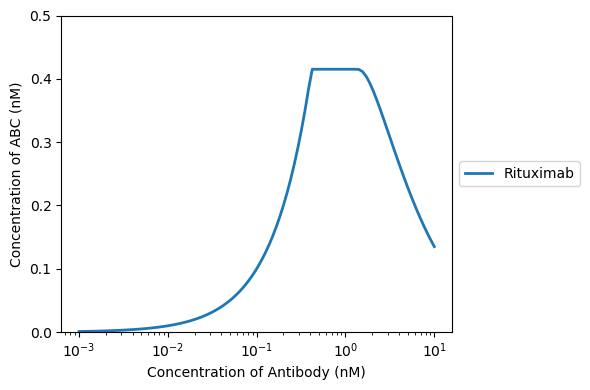

In [337]:
#Create the figure and set the layout
fig = plt.figure(figsize=(6, 4), dpi=100)
gs1 = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs1[0])

#Plot the results
ax.plot(antibody_range,ternary_body,linewidth=2.0)
plt.xlabel('Concentration of Antibody (nM)')
plt.ylabel('Concentration of ABC (nM)')
plt.xscale("log")
plt.ylim(0,0.5)
legend_string = 'Kd = '+ str(Antibody_dissociation) + ' nM'
ax.legend([legend_string])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Rituximab'],loc='center left', bbox_to_anchor=(1, 0.5))

#Creating the plot, saving it, and showing it
gs1.tight_layout(fig)
gs1.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('Figures/Figure4_Rituximab.png')
plt.show()